In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from kan import KAN
from kan.utils import create_dataset

In [137]:
def predict_plot():
    # === 4. Предсказания ===
    with torch.no_grad():
        y_pred_train = model(dataset['train_input'])
        y_pred_test = model(dataset['test_input'])

        # Создаём монотонную сетку для плавного графика предсказаний
        x_grid = np.arange(-2, 2.1, 0.1)  # от -2 до 2 с шагом 0.1
        x_grid_tensor = torch.tensor(x_grid, dtype=torch.float32, device=device).unsqueeze(1)
        y_pred_grid = model(x_grid_tensor).cpu().numpy().flatten()

    # Переводим в numpy
    x_train = dataset['train_input'].cpu().numpy().flatten()
    y_train_true = dataset['train_label'].cpu().numpy().flatten()

    x_test = dataset['test_input'].cpu().numpy().flatten()
    y_test_true = dataset['test_label'].cpu().numpy().flatten()
    y_test_pred = y_pred_test.cpu().numpy().flatten()

    # === 5. Визуализация ===
    plt.figure(figsize=(18, 5))

    # --- Истинные значения (тест и обучение) ---
    plt.subplot(1, 3, 1)
    plt.scatter(x_test, y_test_true, s=15, alpha=0.6, label='Истинные (тест)')
    plt.scatter(x_train, y_train_true, s=15, alpha=0.6, label='Истинные (обучающая)')
    # Идеальная кривая
    x_clean = np.linspace(-2, 2, 300)
    y_clean = f_clean(x_clean).flatten() 
    plt.plot(x_clean, y_clean, 'r', linewidth=2, label='Идеальная f(x)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Истинные значения')
    plt.legend()
    plt.grid(True)

    # --- Предсказания модели на монотонной сетке ---
    plt.subplot(1, 3, 2)
    plt.plot(x_grid, y_pred_grid, color='green', linewidth=2, label='Предсказания (сетка)')
    plt.scatter(x_test, y_test_true, s=15, alpha=0.6, label='Истинные (тест)')
    plt.scatter(x_train, y_train_true, s=15, alpha=0.6, label='Истинные (обучающая)')
    plt.xlabel('x')
    plt.ylabel('ŷ')
    plt.title('Предсказания KAN (на сетке x ∈ [-2, 2], Δx=0.1)')
    plt.legend()
    plt.grid(True)

    # --- Ошибка (тест) ---
    error = np.abs(y_test_true - y_test_pred)
    plt.subplot(1, 3, 3)
    plt.scatter(x_test, error, s=15, alpha=0.6, color='purple')
    plt.xlabel('x')
    plt.ylabel('|y - ŷ|')
    plt.title('Абсолютная ошибка (тест)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


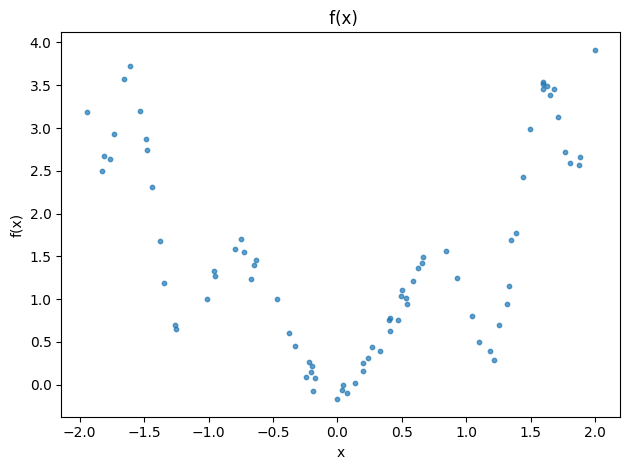

In [ ]:
# === 1. Определяем зашумлённую функцию ===
def f_clean(x):
    # x — массив numpy или тензор PyTorch, shape (N,) или (N, 1)
    if isinstance(x, torch.Tensor):
        return torch.sin(torch.pi * x[:, [0]]**2) + x[:, [0]]**2
    else:
        # x — numpy array, shape (N,) или (N, 1)
        x = np.atleast_1d(x).reshape(-1, 1)
        return np.sin(np.pi * x[:, 0]**2) + x[:, 0]**2
def f_noisy(x, noise_level=0.1):
    y_clean = f_clean(x)  # используем общую чистую функцию
    noise = torch.randn_like(y_clean) * noise_level
    return y_clean + noise

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# === 2. Создаём датасет через create_dataset ===
dataset = create_dataset(
    f=lambda x: f_noisy(x, noise_level=0.1),
    n_var=1,
    ranges=[-2, 2],       # x и y ∈ [-2, 2]
    train_num=80,
    test_num=20,
    device=device,
    seed = 10
)

# Извлекаем данные
x_train = dataset['train_input'].cpu().numpy()  # shape: (1000, 2)
y_train = dataset['train_label'].cpu().numpy().flatten()  # shape: (1000,)

# === 3. Визуализация ===

# --- 3D scatter plot ---
fig, ax = plt.subplots()


# --- 2D scatter (x vs f) с цветом по y ---

scatter = ax.scatter(x_train[:, 0], y_train, s=10, alpha=0.7)
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_title(' f(x)')


plt.tight_layout()
plt.show()

cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.27e-02 | test_loss: 1.20e-01 | reg: 1.15e+01 | : 100%|█| 150/150 [00:30<00:00,  4.88


saving model version 0.1
Модель после обучения:


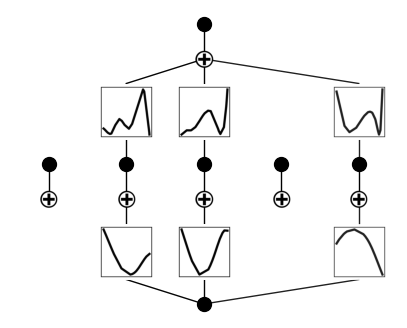

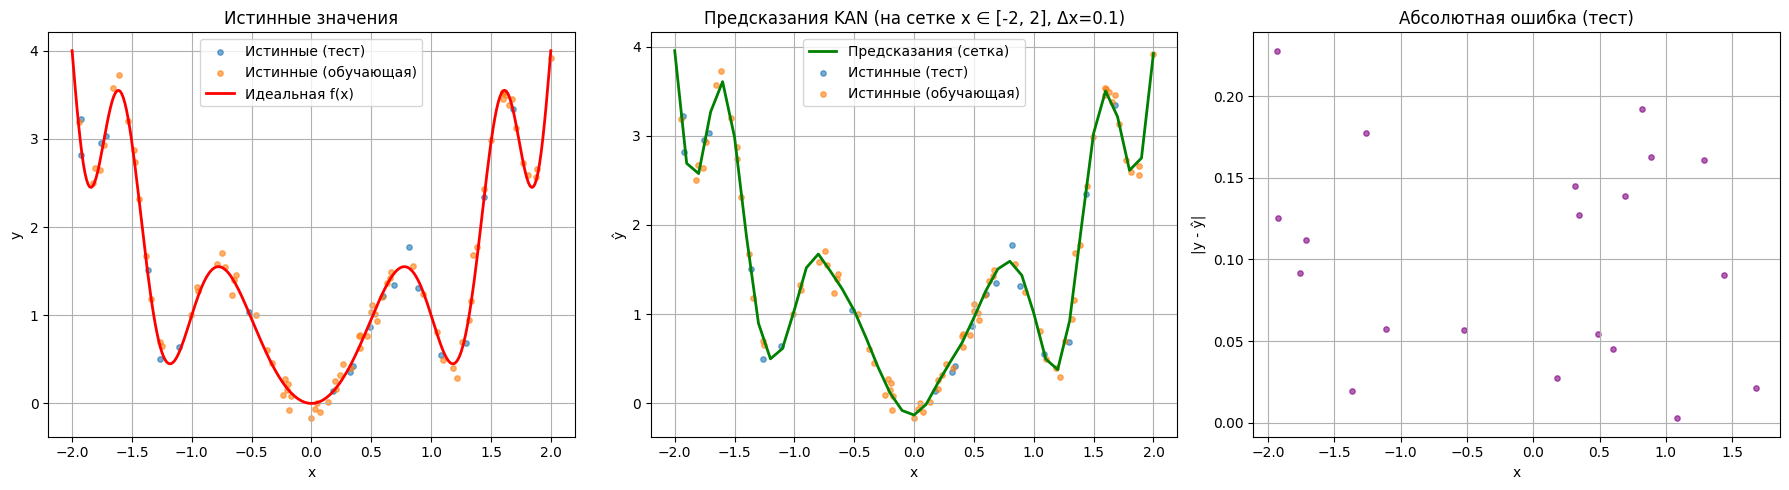

saving model version 0.2
Модель после прореживания:


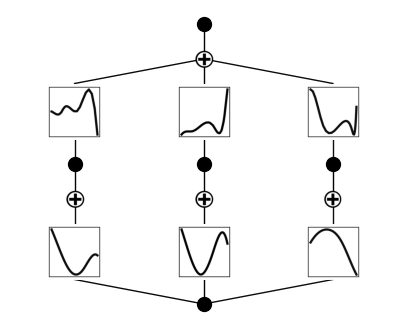

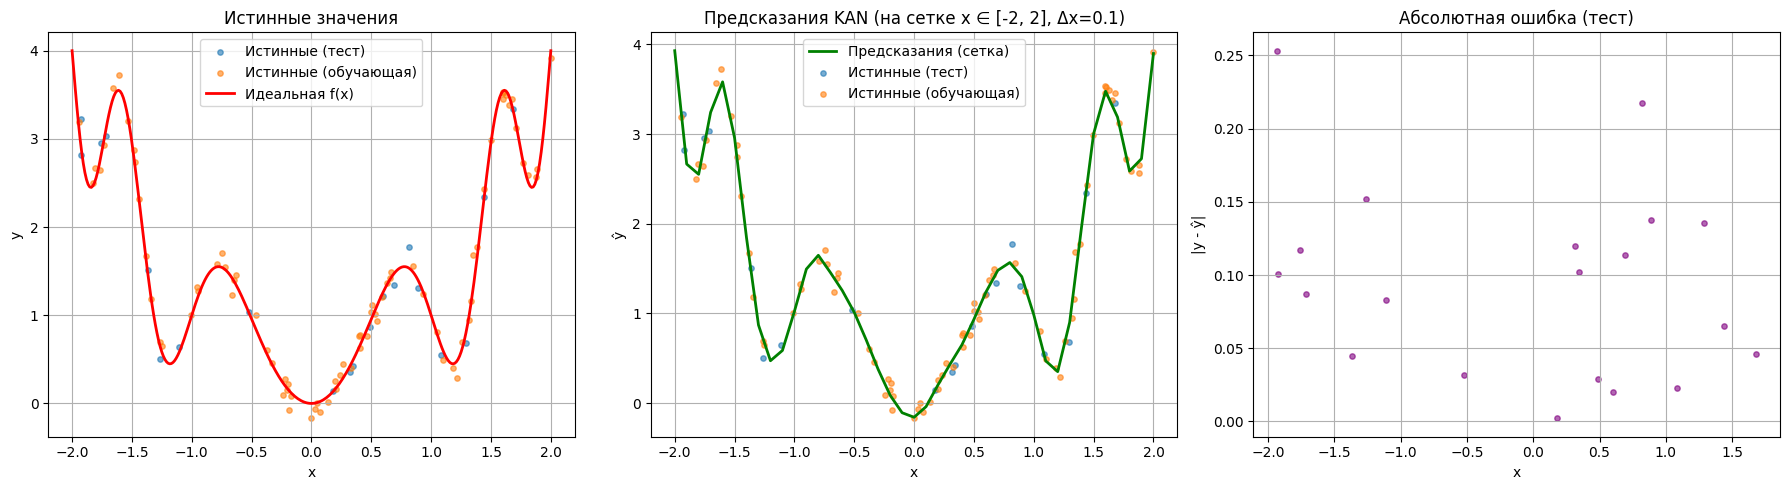

| train_loss: 7.98e-02 | test_loss: 1.30e-01 | reg: 1.17e+01 | : 100%|█| 70/70 [00:14<00:00,  4.96it


saving model version 0.3
Модель после второго обучения:


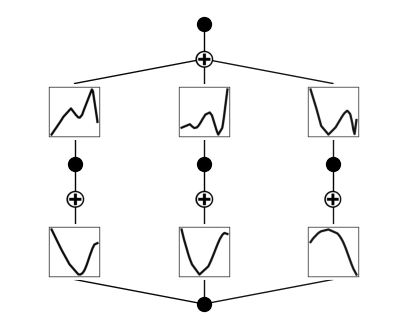

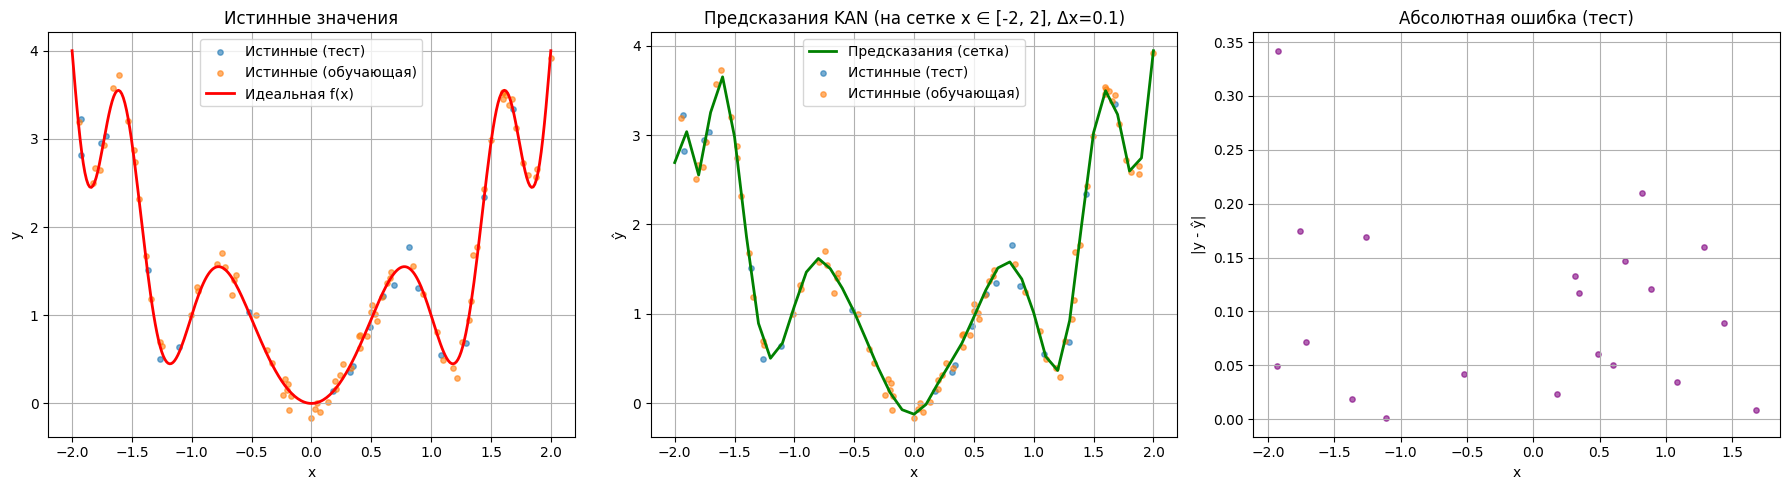

In [ ]:
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[1,5, 1], grid=3, k=3, seed=42, device=device)
model.fit(dataset, opt="LBFGS", steps=150, lamb=0.001)
print(f'Модель после обучения:')
model.plot()
predict_plot()
model = model.prune()
print(f'Модель после прореживания:')
model.plot()
predict_plot()
model.fit(dataset, opt="LBFGS", steps=70, lamb=0.001, update_grid=False)
print(f'Модель после второго обучения:')
model.plot()
predict_plot()

fixing (0,0,0) with x, r2=0.08302067417442757, c=1
fixing (0,0,1) with sin, r2=0.9782870216352518, c=2
fixing (0,0,2) with sin, r2=0.9883242907080287, c=2
fixing (1,0,0) with x, r2=0.3505791792764837, c=1
fixing (1,1,0) with x, r2=0.10227019473541135, c=1
fixing (1,2,0) with x, r2=0.46135006880155477, c=1
saving model version 0.4


| train_loss: 5.90e-01 | test_loss: 6.06e-01 | reg: 0.00e+00 | : 100%|█| 20/20 [00:05<00:00,  3.44it


saving model version 0.5
0.215012988629133*x_1 - 4.64808854652214*sin(1.75007381688433*x_1 - 4.97009575488035) - 3.40119992375415*sin(1.94249161503188*x_1 + 4.4373490027665) + 1.65147197887239


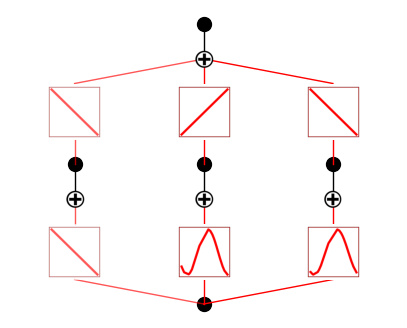

In [149]:
# 3. Символьная подгонка
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
#lib = ['sin', 'x^2']
model.auto_symbolic(lib=lib)

# 4. Финальное обучение с фиксированными функциями
model.fit(dataset, opt="LBFGS", steps=20, lamb=0.0001, update_grid=False)
print(model.symbolic_formula()[0][0])
model.plot()

In [150]:
ex_round(model.symbolic_formula()[0][0],4)

0.215*x_1 - 4.6481*sin(1.7501*x_1 - 4.9701) - 3.4012*sin(1.9425*x_1 + 4.4373) + 1.6515

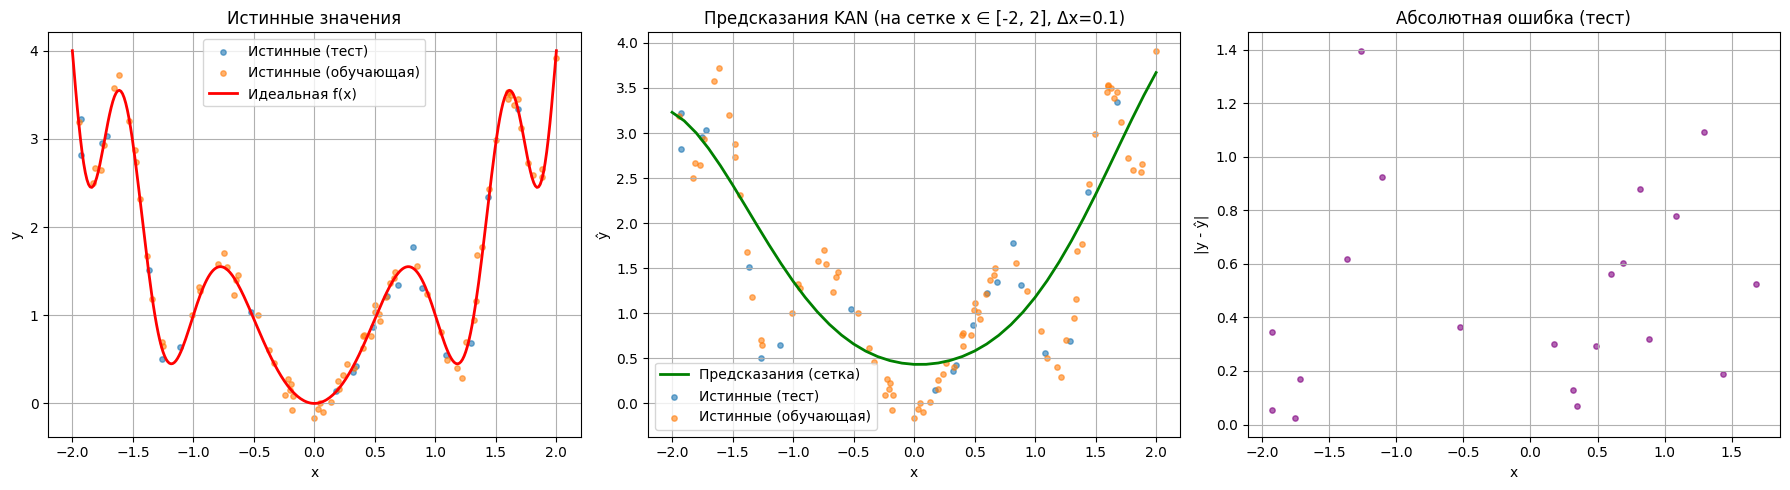

In [152]:
predict_plot()